<a href="https://colab.research.google.com/github/wormulus/ML-Ensemble-Classification/blob/main/ML_Prediction_on_Census.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
#@title Setup
#import things
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

#data path -- from UCI's archives
data_path = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"

col_names = [
    'age', 'workclass', 'fnlwgt','education', 'education-num', 'marital-status',
    'occupation', 'relationship', 'race', 'sex', 'capital-gain','capital-loss',
    'hours-per-week','native-country', 'income'
]

#read csv as pandas dataframe
df = pd.read_csv(data_path, header=None, names = col_names)

#clean columns by stripping extra whitespace for columns of type "object"
for c in df.select_dtypes(include=['object']).columns:
    df[c] = df[c].str.strip()

target_column = "income"
raw_feature_cols = [
    'age',
    'education-num',
    'workclass',
    'hours-per-week',
    'sex',
    'race'
]


In [10]:
#@title < and > 50k Split, Features data types
#Percentage of samples with income < and > 50k
print('Percentage of samples with income < and > 50k')
print(df['income'].value_counts(normalize=True))

#Data types of features
print('\nData types of features')
print(df[raw_feature_cols].dtypes)

Percentage of samples with income < and > 50k
<=50K    0.75919
>50K     0.24081
Name: income, dtype: float64

Data types of features
age                int64
education-num      int64
workclass         object
hours-per-week     int64
sex               object
race              object
dtype: object


In [12]:
#@title Prepping Data, Classifying, Training and Scoring
#Preparing the features
X = pd.get_dummies(df[raw_feature_cols], drop_first=True)

print(X.head())

#Convert target variable to binary
#0 if < 50k, otherwise 1
y = np.where(df[target_column] == '<=50K', 0, 1)

#train-test split of 70/30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

#decision_stump as base estimator
decision_stump = DecisionTreeClassifier(max_depth=1)

#Create AdaBoost Classifier
ada_classifier = AdaBoostClassifier(base_estimator = decision_stump)
#Create GradientBoost Classifier
grad_classifier = GradientBoostingClassifier()

#Fit models and get predictions
ada_classifier.fit(X_train, y_train)
y_pred_ada = ada_classifier.predict(X_test)

grad_classifier.fit(X_train, y_train)
y_pred_grad = grad_classifier.predict(X_test)

#Print accuracy and F1
print(f"AdaBoost accuracy: {accuracy_score(y_test, y_pred_ada)}")
print(f"AdaBoost f1-score: {f1_score(y_test, y_pred_ada)}")

print(f"Gradient Boost accuracy: {accuracy_score(y_test, y_pred_grad)}")
print(f"Gradient Boost f1-score: {f1_score(y_test, y_pred_grad)}")


   age  education-num  hours-per-week  workclass_Federal-gov  \
0   39             13              40                      0   
1   50             13              13                      0   
2   38              9              40                      0   
3   53              7              40                      0   
4   28             13              40                      0   

   workclass_Local-gov  workclass_Never-worked  workclass_Private  \
0                    0                       0                  0   
1                    0                       0                  0   
2                    0                       0                  1   
3                    0                       0                  1   
4                    0                       0                  1   

   workclass_Self-emp-inc  workclass_Self-emp-not-inc  workclass_State-gov  \
0                       0                           0                    1   
1                       0                   

Fitting 5 folds for each of 5 candidates, totalling 25 fits


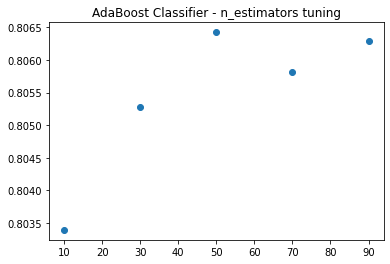

Fitting 5 folds for each of 5 candidates, totalling 25 fits


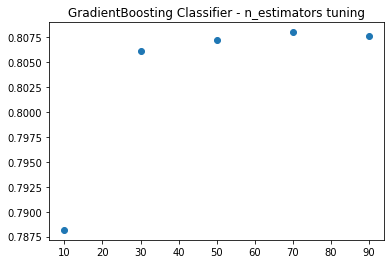

In [16]:
#@title Hyperparameter Tuning

#n_estimators to test
n_estimators_list = [10, 30, 50, 70, 90]

#Using GridSearchCV for AdaBoost
from sklearn.model_selection import GridSearchCV
estimator_parameters = {'n_estimators': n_estimators_list}
ada_gridsearch = GridSearchCV(ada_classifier, estimator_parameters, cv=5, scoring='accuracy', verbose=True)
ada_gridsearch.fit(X_train, y_train)

#plot mean test scores
ada_scores_list = ada_gridsearch.cv_results_['mean_test_score']
plt.scatter(n_estimators_list, ada_scores_list)
plt.title("AdaBoost Classifier - n_estimators tuning")
plt.show()

#Using GridSearchCV for GradBoost
from sklearn.model_selection import GridSearchCV
estimator_parameters = {'n_estimators': n_estimators_list}
grad_gridsearch = GridSearchCV(grad_classifier, estimator_parameters, cv=5, scoring='accuracy', verbose=True)
grad_gridsearch.fit(X_train, y_train)

#plot mean test scores
grad_scores_list = grad_gridsearch.cv_results_['mean_test_score']
plt.scatter(n_estimators_list, grad_scores_list)
plt.title("GradientBoosting Classifier - n_estimators tuning")
plt.show()


## Conclusions

* AdaBoost accuracy: 0.8166
* AdaBoost f1-score: 0.5188
* Gradient Boost accuracy: 0.8234
* Gradient Boost f1-score: 0.5416

From this, I would say we should use the Gradient Boost model. Looking at the n_estimators hyperparameter tuning, I would suggest using n_estimators of at least 50, but not more than 70.